In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image

import scipy.fftpack as sfft
import random
import imageio
import sys
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
### 1920 x 1200 SLM
### pixel values range from 0-> 255, corresponding to a 0->2pi phase shift.

In [2]:
### Create diffraction grating
precision = 1 ### Multiplier to get better tunability
blank = np.empty((1920*precision,1200*precision),dtype=float)
grating = blank.copy()
width_pix = 8 ### choose this to be over 8, ideally
length_pix = 8 ### choose this to be over 8, ideally
numcols = np.size(grating[0])  ## should be 1920
numrows = np.size(grating[...,0])  ## should be 1200
max_iter = 30 ### for GS algo

### Settings for image generation
numframes = 30 # set number of frames in movie
min_width_pix = 8
min_length_pix = 8
stepsize_width_pix = 1 # must be integer
stepsize_length_pix = 1 # must be integer


def Ger_Sax_algo(InputImg, width, height, max_iter):
    TwoDImg = np.reshape(InputImg, (-1, width))

    pm_s = np.random.rand(height, width)
    pm_f = np.ones((height, width))
    am_s = np.sqrt(TwoDImg) / 2
    am_f = np.ones((height, width))

    signal_s = am_s*np.exp(pm_s * 1j)

    for iter in range(max_iter):
        signal_f = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(signal_s)))
        pm_f = np.angle(signal_f)
        signal_f = am_f*np.exp(pm_f * 1j)
        signal_s = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(signal_f)))
        pm_s = np.angle(signal_s)
        signal_s = am_s*np.exp(pm_s * 1j)

    phase_mask = np.uint8(((pm_f/(2*np.pi))*256)+128)
    ### flat_phase = phase_mask.flatten()

    return phase_mask

### SLM Direct Images
# Create an SLM grating with sinusoidal pixel values

def gen_tweezers(xrad, yrad, xspacing, yspacing, xmin, xmax, ymin,ymax):
    simplegrating = np.zeros(np.shape(blank))

    for i in range(xmin,xmax):
        for j in range(ymin,ymax):
            pixcoord = 0
            distj1 = j  % yspacing
            disti1 = i  % xspacing
            distj2 = (yspacing - j) % yspacing
            disti2 = (xspacing - i) % xspacing
            distj = min((distj1, distj2))
            disti = min((disti1, disti2))
            if (distj < xrad) and (disti < yrad):
                pixcoord = 255
            simplegrating[j,i] = pixcoord
    return simplegrating

def gen_tweezers_precise(xrad, yrad, xspacing, yspacing, xstart, xend, ystart,yend):
    simplegrating = np.zeros(np.shape(blank))

    for i in range(xstart, xend):
        for j in range(ystart,yend):
            pixcoord = 0
            distj1 = (j - ystart)  % yspacing
            disti1 = (i - xstart) % xspacing
            distj2 = (yspacing - (j-ystart)) % yspacing
            disti2 = (xspacing - (i-xstart)) % xspacing
            distj = min((distj1, distj2))
            disti = min((disti1, disti2))
            if (distj < xrad) and (disti < yrad):
                pixcoord = 255
            simplegrating[j,i] = pixcoord
    return simplegrating

def gen_circlemask(radius):
    simplegrating = np.zeros(np.shape(blank))
    for i in range(1920 * precision):
        for j in range(1200 * precision):
            pixcoord = 0
            if (((1920 * precision)/2 - i)**2 + ((1200 * precision)/2 - j)**2)**0.5 < radius:
                pixcoord = 255
            simplegrating[i,j] = pixcoord
    return simplegrating


### Image writing!

def f_grating(pattern):
    return Ger_Sax_algo(pattern, numcols, numrows, max_iter)

def writeimg(array, name):
    data = Image.fromarray(array).convert('RGB')
    data.save(name+".bmp")
    return print(name+" saved succesfully.")

def print_1Dimgs(function, numframes, min_width_pix, stepsize_pix):
    width = min_width_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width)
        writeimg(array, name)
        width += stepsize_pix
    return print("Image writing successful.")

def print_2Dimgs(function, numframes, min_width_pix, min_length_pix, stepsize_w_pix, stepsize_l_pix):
    width = min_width_pix
    length = min_length_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width, length)
        writeimg(array, name)
        width += stepsize_w_pix
        length += stepsize_l_pix
    return print("Image writing successful.")

def print_f_1Dimgs(function, numframes, min_width_pix, stepsize_pix):
    width = min_width_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width)
        farray = f_grating(array)
        writeimg(farray, name)
        width += stepsize_pix
    return print("Image writing successful.")

def print_f_2Dimgs(function, numframes, min_width_pix, min_length_pix, stepsize_w_pix, stepsize_l_pix):
    width = min_width_pix
    length = min_length_pix
    for i in range(numframes):
        name = str(100+i)
        array = function(width, length)
        farray = f_grating(array)
        writeimg(farray, name)
        width += stepsize_w_pix
        length += stepsize_l_pix
    return print("Image writing successful.")


def slm_2D_simulator(function, maxiter, min_width_pix, min_length_pix):
    slmarray = function(min_width_pix, min_length_pix)
    slmimage = Ger_Sax_algo(slmarray, numcols, numrows, maxiter)
    fourierimage = np.abs(np.fft.fft2(slmimage))
    fourierimage = fourierimage/np.max(fourierimage)*255
    writeimg(fourierimage,"simulim")
    return print("Print successful")


In [3]:
# test 1
# arr = gen_tweezers(3, 3, 33, 33, int(precision*(1200/8)*2), int(precision*(1200/8)*6), int(precision*(1920/16)*2), int(precision*(1920/16)*7))

# arr1 = gen_tweezers(1,1, int(precision*9 * 1200/1920), precision*9, int(precision*(1200/16)*6), int(precision*(1200/16)*10), int(precision*(1920/16)*5), int(precision*(1920/16)*7.5))
arr1 = gen_tweezers_precise(1,1, int(precision*10 * 1200/1920), precision*10, int(precision*1200/32*16)+0, int(precision*1200/32*18)+0, int(precision*1920/32*13)+0, int(precision*1920/32*15)+0)
imgname = "precision1spacing10off0_0"
target = writeimg(arr1, f"{imgname}")

precision1spacing10off0_0 saved succesfully.


In [37]:
### Testing Ger-Sax algorithm

def epsilon(u_int, target_im):
    max = np.max(u_int[target_im==1]) #Max value of the obtained intensity at the tweezers position
    min = np.min(u_int[target_im==1]) #Min value of the obtained intensity at the tweezers position
    error = (max-min)/(max+min)
    #print("Error :", error)
    return error

def join_phase_ampl(phase,ampl):
    tmp=np.zeros((ampl.shape[0],ampl.shape[1]),dtype=complex)
    tmp = ampl*np.exp(phase*1j)
    return tmp

def Beam_shape(sizex,sizey,sigma,mu):
    x, y = np.meshgrid(np.linspace(-1,1,sizex), np.linspace(-1,1,sizey))
    d = np.sqrt(x*x+y*y)
    g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )
    return g

def surface_plot (matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)

def norm(matrix):
    min=np.min(matrix);max=np.max(matrix)
    return((matrix-min)/(max-min))

def bin_norm_clip(matrix):  # Function that clips the values to 0-255 (SLM standard)
    matrix=np.array(target_im, dtype=np.uint8)
    matrix=norm(matrix)
    return(matrix)

def screwone(list):
    for number in list:
        if number == 1:
            number = number - 0.01
    return number

def weights(w,target_im,w_prev,std_int): # This weight function works only where the intensity == 1 (discrete tweezers)
    w[target_im==1] = np.sqrt((target_im[target_im==1] / std_int[target_im==1])) * w_prev[target_im==1]
    w[target_im!=1] = np.sqrt(1 / (1-screwone(std_int[target_im!=1]))) * w_prev[target_im!=1]

    return (w)

def discretize_phase(phase):
    phase=np.round((phase+np.pi)*255/(2*np.pi))
    return(phase)

def undiscretize_phase(phase):
    phase=phase/255*(2*np.pi)-np.pi
    return(phase)

def set_circlemask(inputmatrix, radius):
    copy = inputmatrix
    for i in range(1920):
        for j in range(1200):
            pixcoord = inputmatrix[i,j]
            if (((1920)/2 - i)**2 + ((1200)/2 - j)**2)**0.5 > radius:
                pixcoord = 0
            copy[i,j] = pixcoord
    return copy

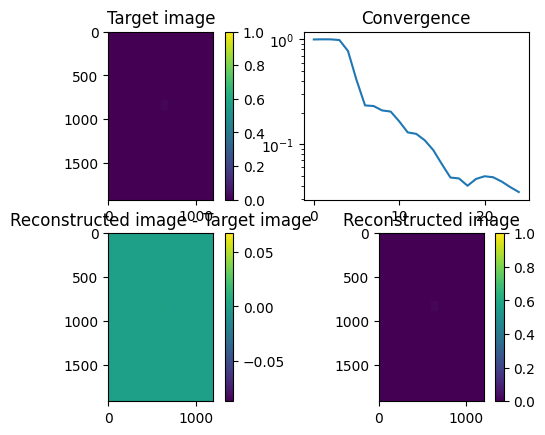

In [38]:

target_im = np.asarray(Image.open(f"{imgname}.bmp"))
newtar = np.zeros((1920*precision,1200*precision))

for i in range(1920*precision):
  for j in range(1200*precision):
      newtar[i,j] = 0
      if target_im[i,j,1] > 0.1:
        newtar[i,j] = 1
target_im = newtar

SIZE_X, SIZE_Y = 1920, 1200
fig, axs = plt.subplots(2,2)
im0=axs[0,0].imshow(target_im)
plt.colorbar(im0,ax=axs[0,0])
axs[0,0].set_title('Target image')


# The initial weights are all = 1.
n_rep =25
w=np.ones((SIZE_X*precision,SIZE_Y*precision))
# The amplitude in the fourier plane is a Gaussian (beam)
### radius
radiusinput = 650
PS_shape=Beam_shape(SIZE_X,SIZE_Y,255,0)
w_prev=target_im

errors=[]
u=np.zeros((SIZE_X,SIZE_Y),dtype=complex)
phase=2*np.pi*np.random.rand(SIZE_X,SIZE_Y)-np.pi

for rep in range(n_rep):
    # Fourier plane, random phase (at the round 1) and gaussian beam
    u=join_phase_ampl(phase,PS_shape.T)
        # To the real plane...
    u = sfft.fft2(u)
    u = set_circlemask(sfft.fftshift(u), radiusinput)
    uscaled = np.repeat(np.repeat(u, precision, axis=0), precision, axis=1)
    # Calculate the intensity
    int=np.square(np.abs(uscaled))
    # Let's renormalize the intensity in the range [0,1]
    std_int=norm(int)
    # What's the distance from the target intensity?
    errors.append(epsilon(std_int, target_im))
    phase=np.angle(uscaled)
    ## Here I don't care about the discretization of the phase because we're in real space (that is actually the fourier plane for the code)
    #Generate weights and use them to obtain u
    w=weights(w,target_im,w_prev,std_int)
    w=norm(w)
    w_prev=w
    uscaled=join_phase_ampl(phase,w)
    # Back to our fourier plane
    reshape_u = uscaled.reshape(1920,precision,1200,precision)
    u = np.mean(reshape_u, axis=(-3,-1))
    u = sfft.ifftshift(u)
    u = sfft.ifft2(u)

    # The phase that we need to imprint by the SLM is :
    phase=np.angle(u)
    # This part discretizes the values of phase. The SLM can only produce values in the range [0,255]
    # that corresponds to [0,2pi]. Some values (e.g. 0.5 => 0.5 * 2pi/255) cannot be reproduced by the SLM
    # This discretization takes that in account. (The final phase will be the discretized one)
    phase=discretize_phase(phase)
    phase = phase
    Final_ampl_phase=phase
    phase=undiscretize_phase(phase)

axs[0,1].plot(errors)
axs[0,1].set_yscale('log')
axs[0,1].set_title('Convergence')


im1=axs[1,0].imshow(target_im-std_int)
plt.colorbar(im1,ax=axs[1,0])
axs[1,0].set_title('Reconstructed image - Target image')

im2=axs[1,1].imshow(std_int)
plt.colorbar(im2,ax=axs[1,1])
axs[1,1].set_title('Reconstructed image')
plt.show()

In [ ]:
writeimg(Final_ampl_phase, f"f{imgname}")

fprecision1spacing10off0_0 saved succesfully.


In [8]:
img123 = Image.open(f"f{imgname}.bmp")
img123 = np.asarray(img123)
blank123 = img123[:,:,0]
blank123 = np.exp(1j * blank123 * 2 * np.pi / 256)
maxval = np.amax(blank123)
f123 = np.fft.fftshift(np.fft.fft2(blank123))
mag_spectrum = np.abs(f123)

max_mag = np.max(mag_spectrum)
scaledimg = mag_spectrum / max_mag*255

In [9]:
data = Image.fromarray(scaledimg.T).convert('RGB')
data.save(f"transposed_Simulate_f{imgname}.bmp")

In [10]:
img = Image.open(f"f{imgname}.bmp")
transpose = img.transpose(Image.ROTATE_90)
transpose.save(f"transposed_f{imgname}.bmp")